*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 15: Classifying Images with Deep Convolutional Neural Networks (Part 1/2)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-12-06 

numpy 1.17.4
scipy 1.3.1
matplotlib 3.1.0
tensorflow 2.0.0
tensorflow_datasets 1.2.0


In [2]:
from IPython.display import Image
%matplotlib inline

##  The building blocks of convolutional neural networks

### Understanding CNNs and feature hierarchies

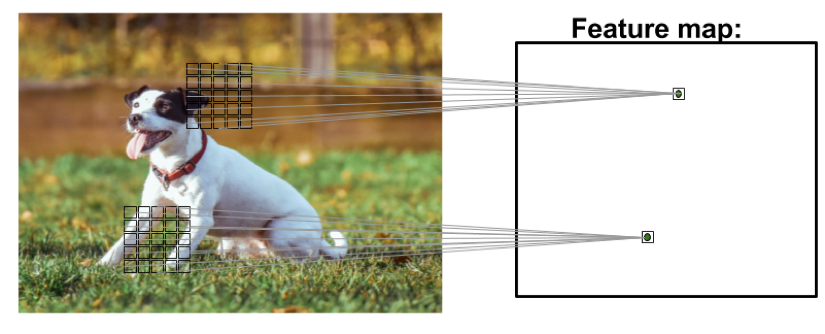

In [3]:
Image(filename='images/15_01.png', width=700)



### Performing discrete convolutions

### Discrete convolutions in one dimension



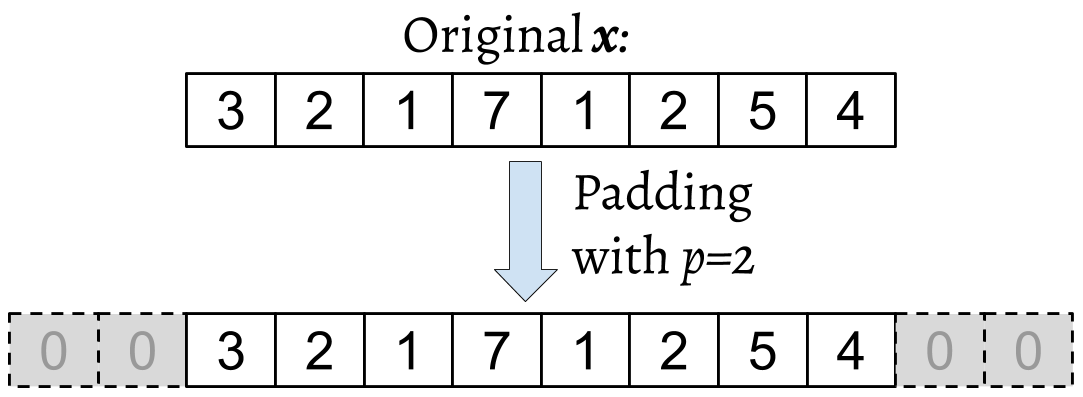

In [4]:
Image(filename='images/15_02.png', width=700)

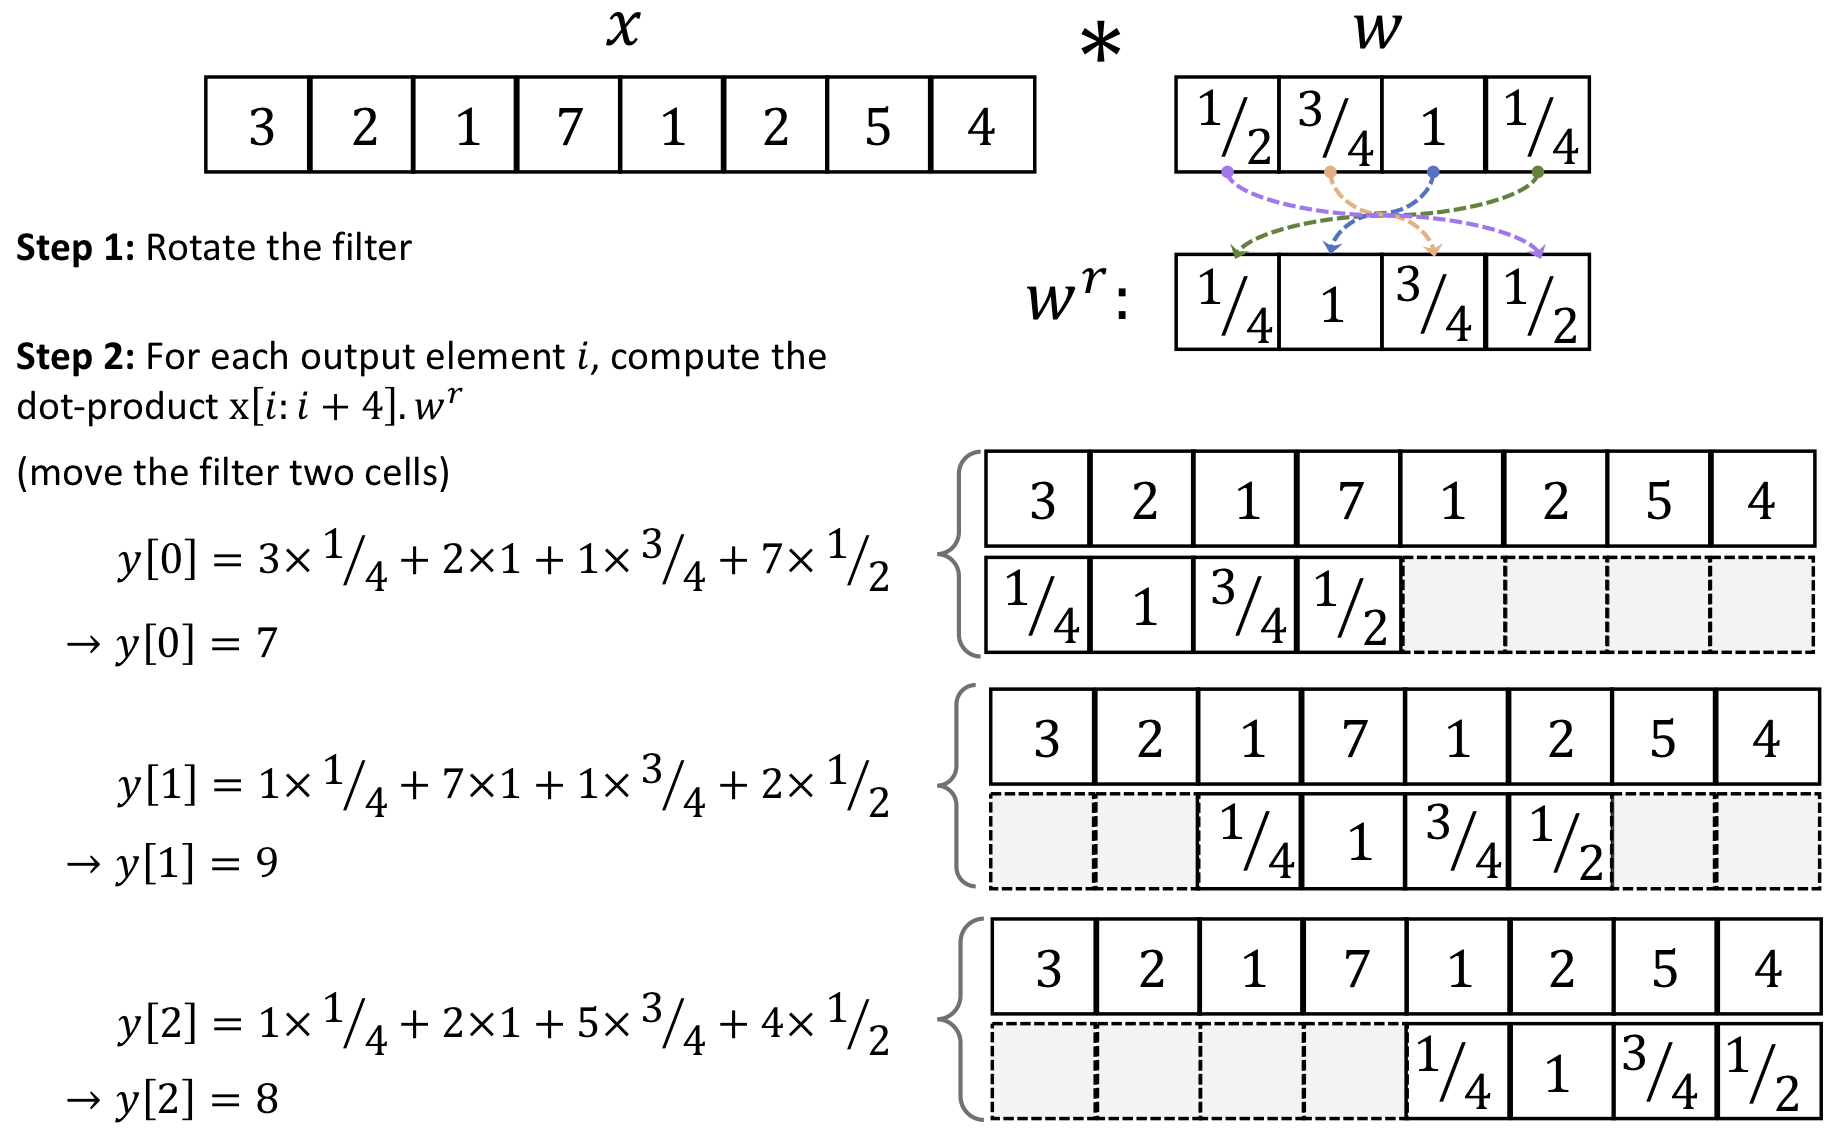

In [5]:
Image(filename='images/15_03.png', width=700)

### Padding inputs to control the size of the output feature maps



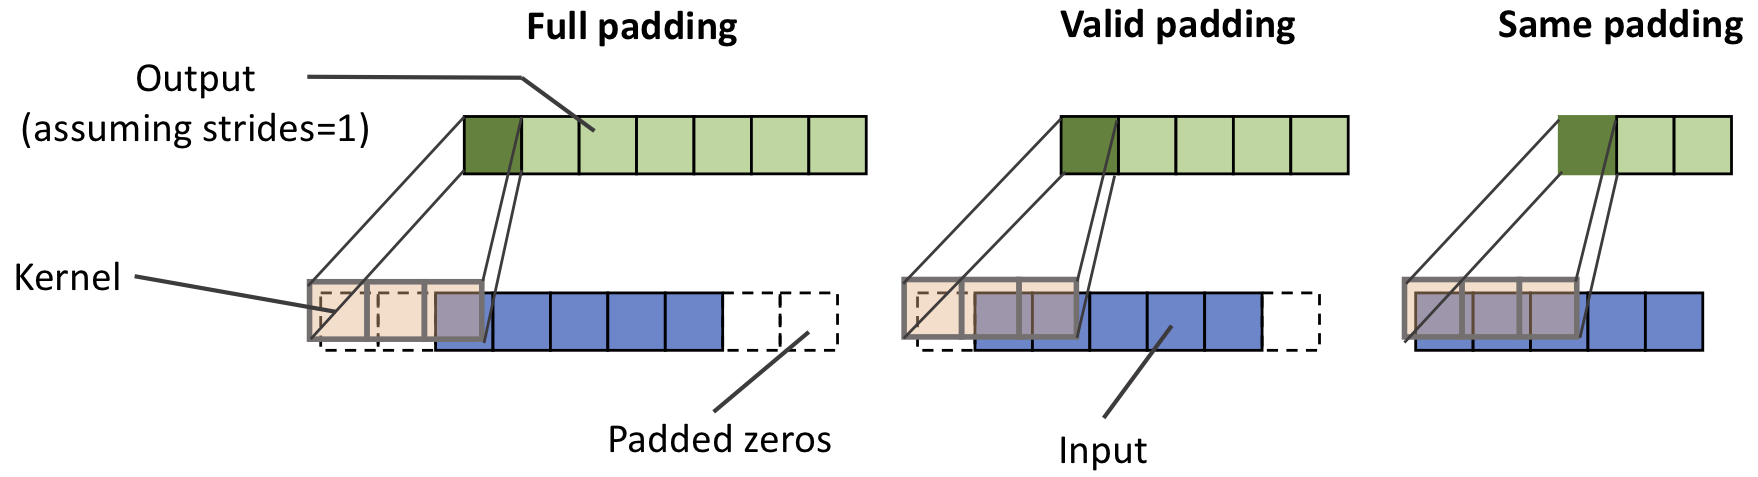

In [6]:
Image(filename='images/15_04.png', width=700)

### Determining the size of the convolution output

In [7]:
import tensorflow as tf
import numpy as np

print('TensorFlow version:', tf.__version__)
print('NumPy version: ', np.__version__)

TensorFlow version: 2.0.0
NumPy version:  1.17.4


In [8]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

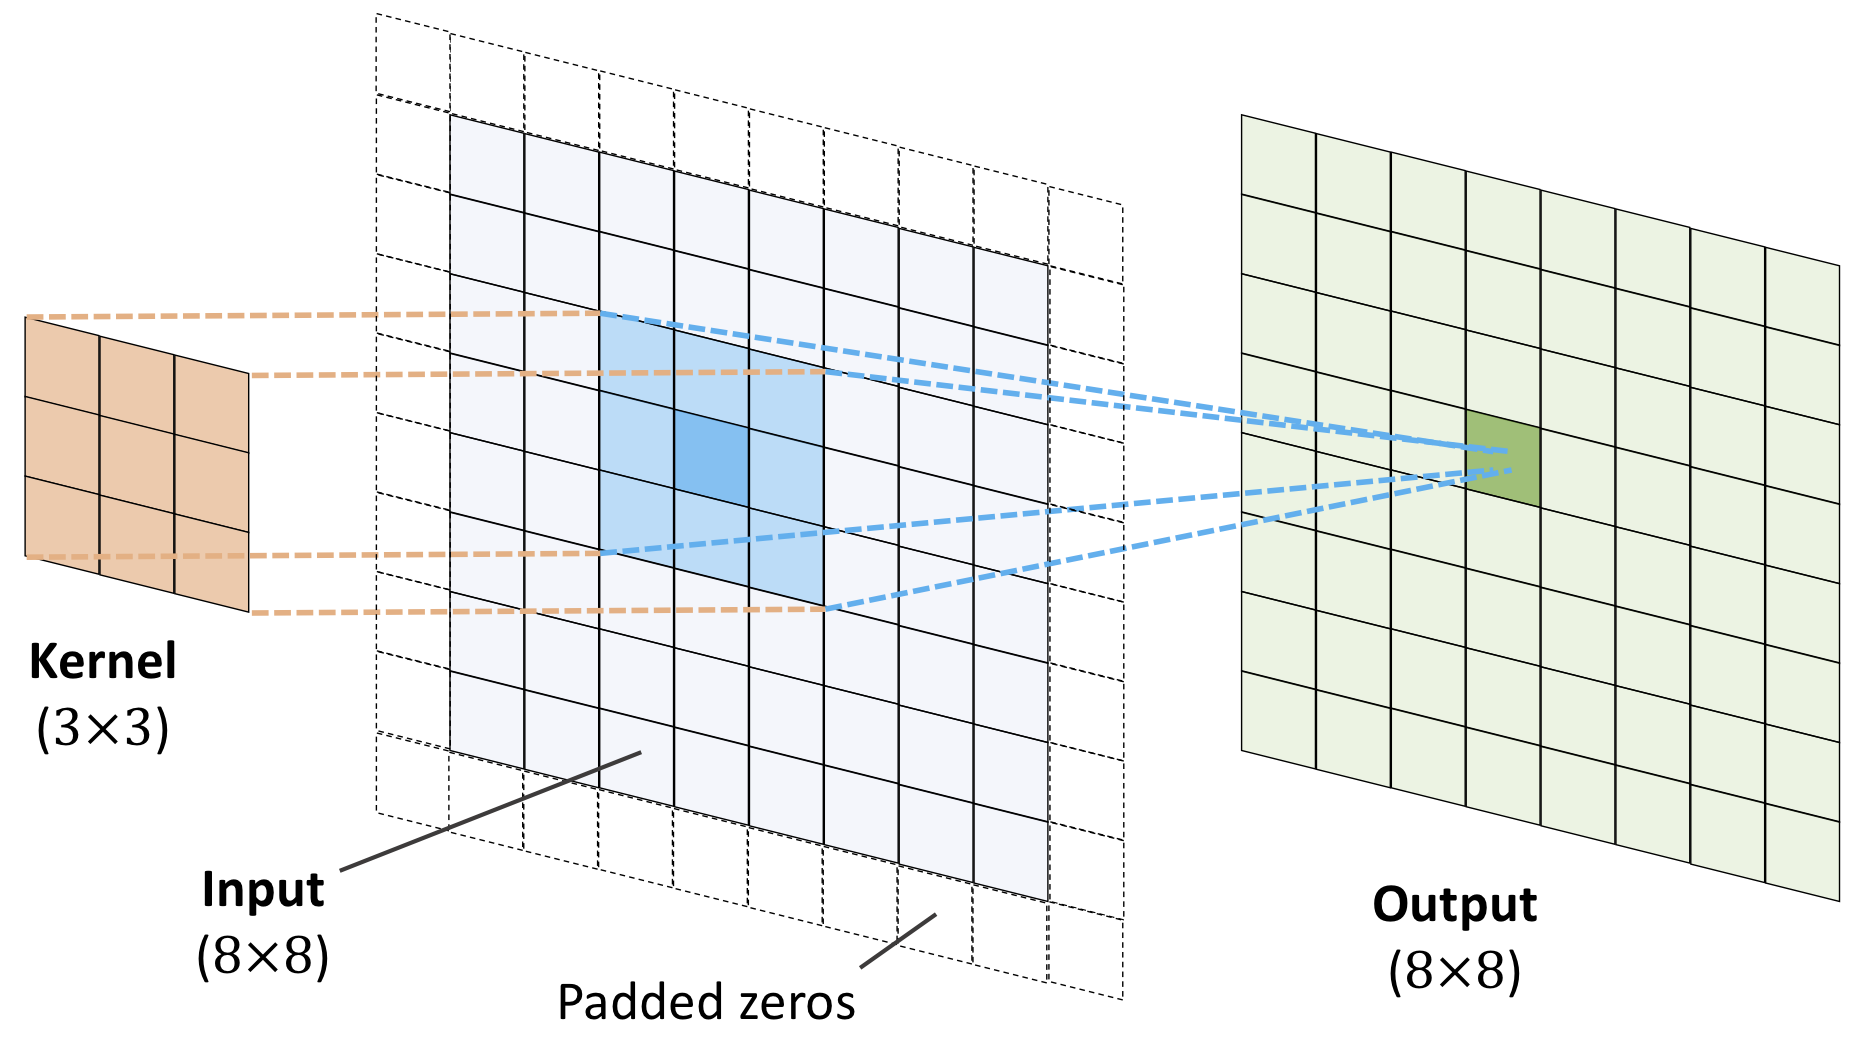

In [9]:
Image(filename='images/15_05.png', width=700)

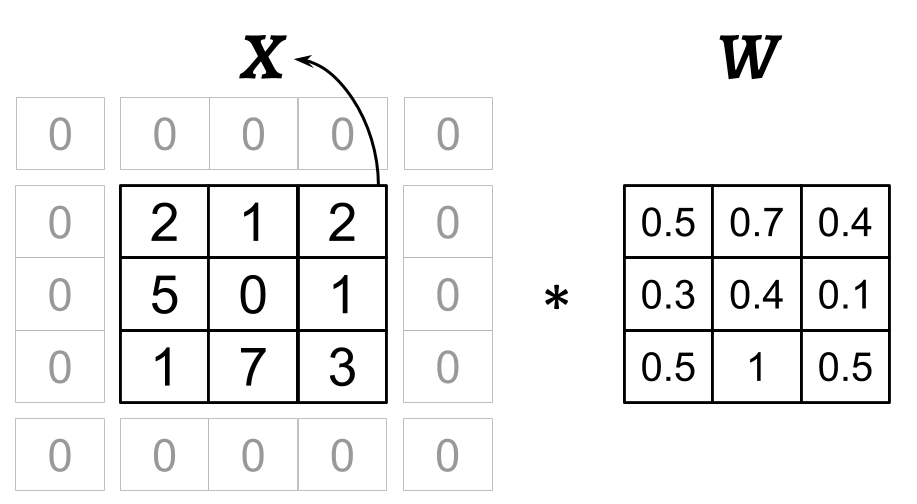

In [10]:
Image(filename='images/15_06.png', width=600)

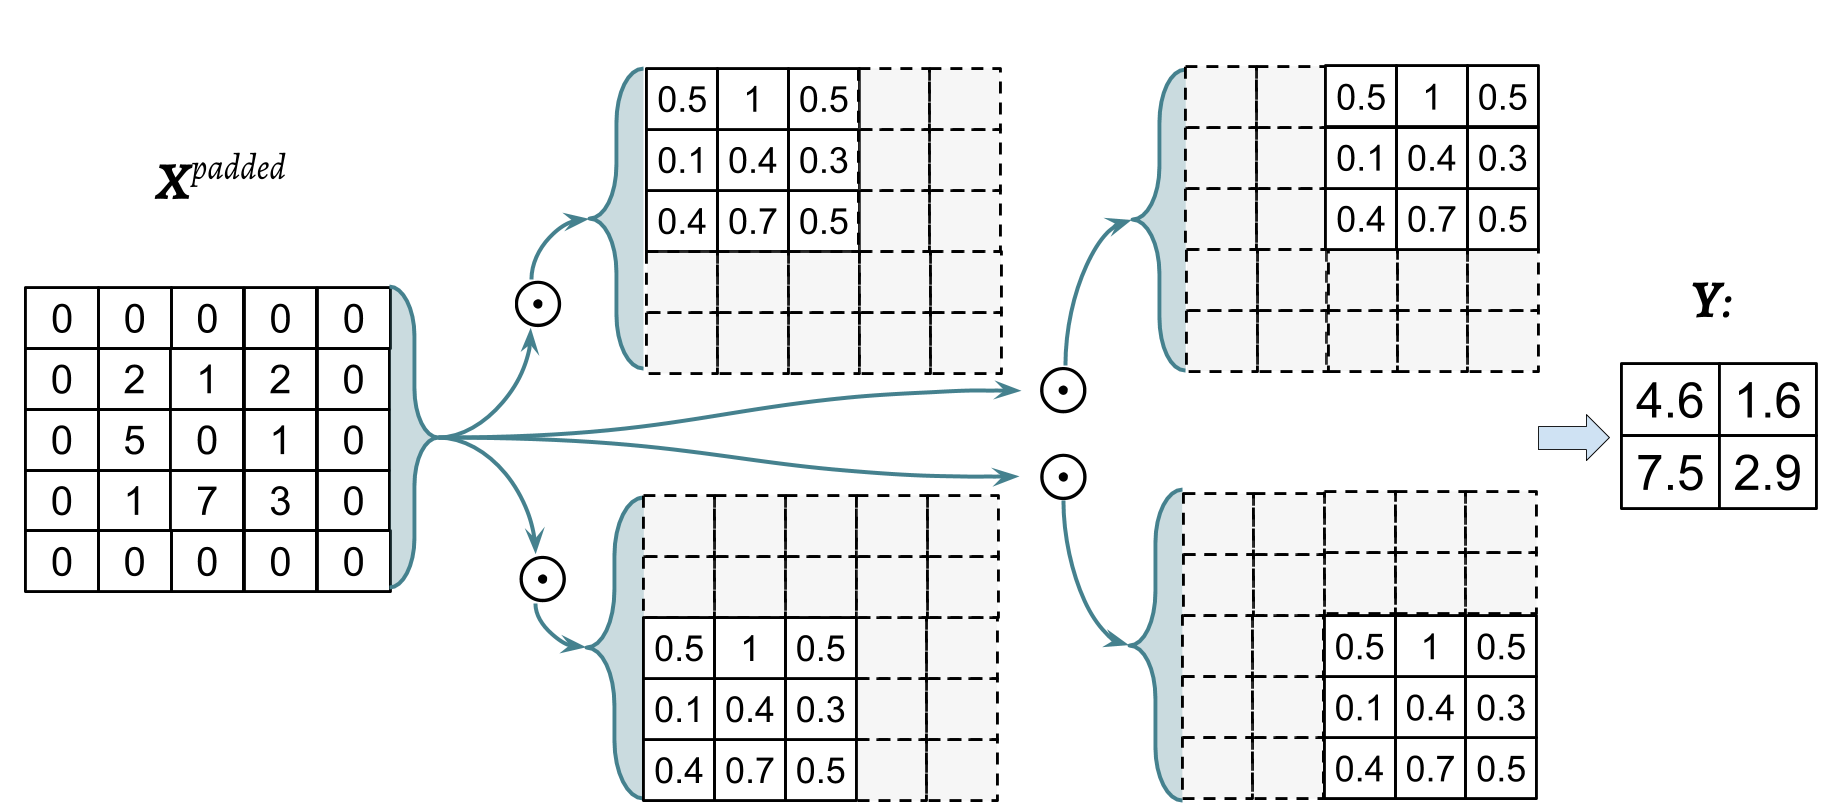

In [11]:
Image(filename='images/15_07.png', width=800)

In [12]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))


Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Subsampling layers

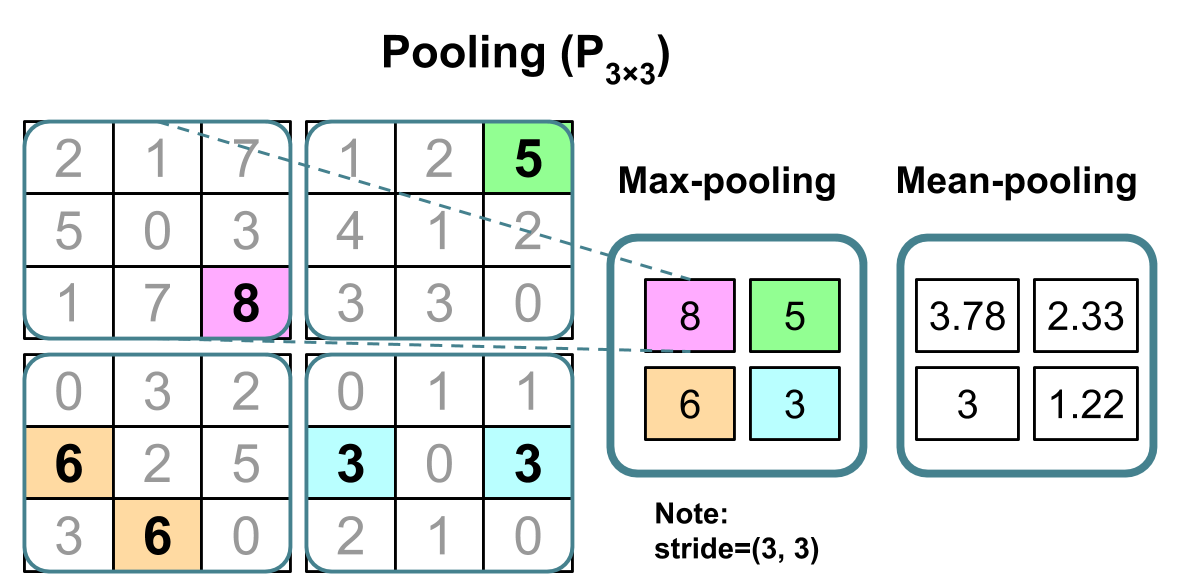

In [13]:
Image(filename='images/15_08.png', width=700)

## Putting everything together – implementing a CNN

### Working with multiple input or color channels



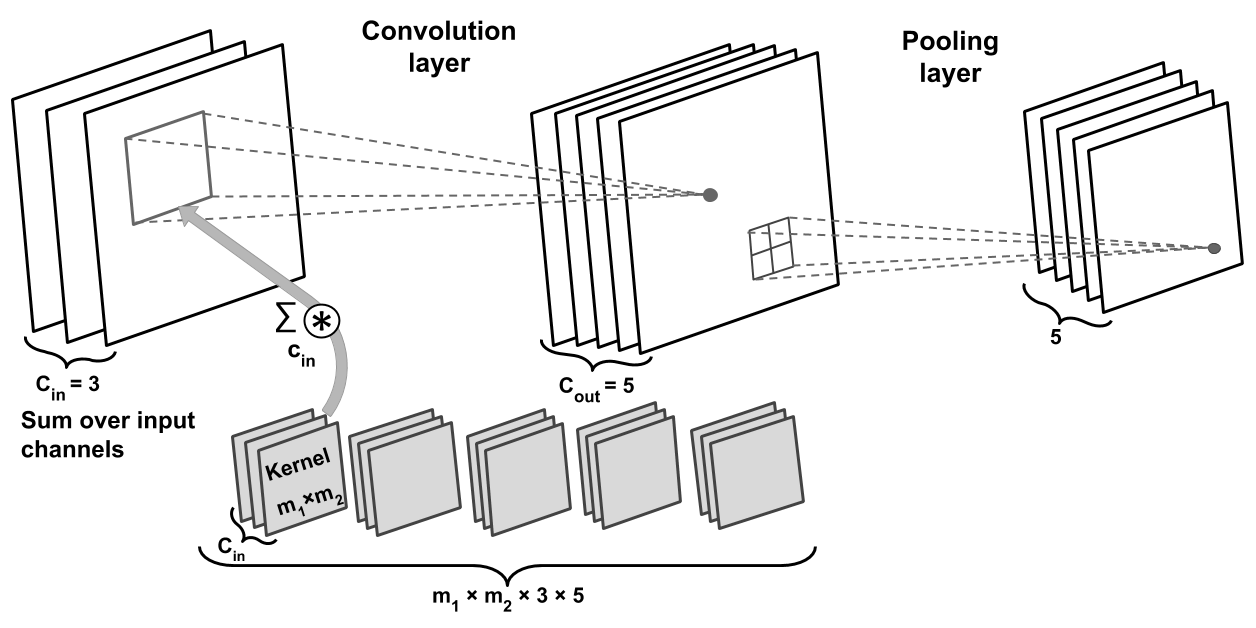

In [14]:
Image(filename='images/15_09.png', width=800)

**TIP: Reading an image file**

In [15]:
import tensorflow as tf


img_raw = tf.io.read_file('example-image.png')
img = tf.image.decode_image(img_raw)
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

Image shape: (252, 221, 3)
Number of channels: 3
Image data type: <dtype: 'uint8'>
tf.Tensor(
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]], shape=(2, 2, 3), dtype=uint8)


In [16]:
import imageio


img = imageio.imread('example-image.png')
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

Image shape: (252, 221, 3)
Number of channels: 3
Image data type: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


**INFO-BOX: The rank of a grayscale image for input to a CNN**

In [17]:
img_raw = tf.io.read_file('example-image-gray.png')
img = tf.image.decode_image(img_raw)
tf.print('Rank:', tf.rank(img))
tf.print('Shape:', img.shape)

Rank: 3
Shape: TensorShape([252, 221, 1])


In [18]:
img = imageio.imread('example-image-gray.png')
tf.print('Rank:', tf.rank(img))
tf.print('Shape:', img.shape)

img_reshaped = tf.reshape(img, (img.shape[0], img.shape[1], 1))
tf.print('New Shape:', img_reshaped.shape)

Rank: 2
Shape: (252, 221)
New Shape: TensorShape([252, 221, 1])


## Regularizing a neural network with dropout



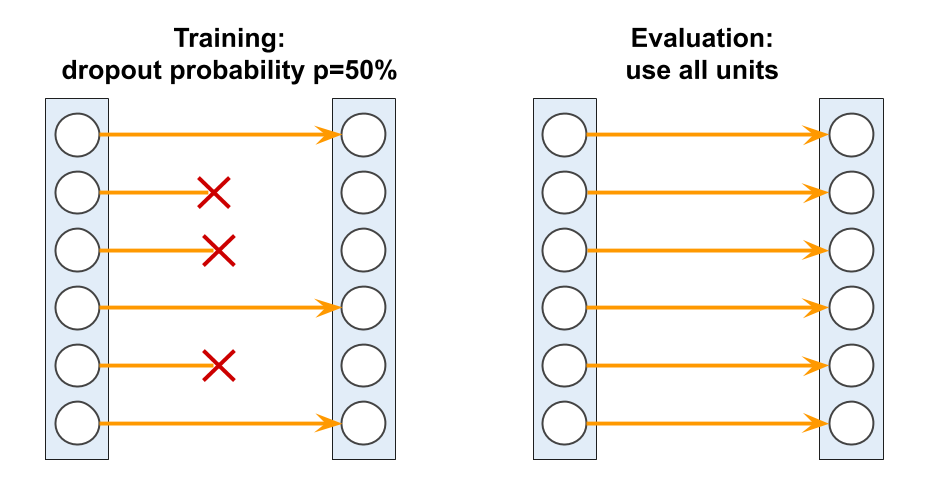

In [19]:
Image(filename='images/15_10.png', width=700)

In [20]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

## Loss Functions for Classification

 * **`BinaryCrossentropy()`**
   * `from_logits=False` 
   * `from_logits=True`

 * **`CategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`
   
 * **`SparseCategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`


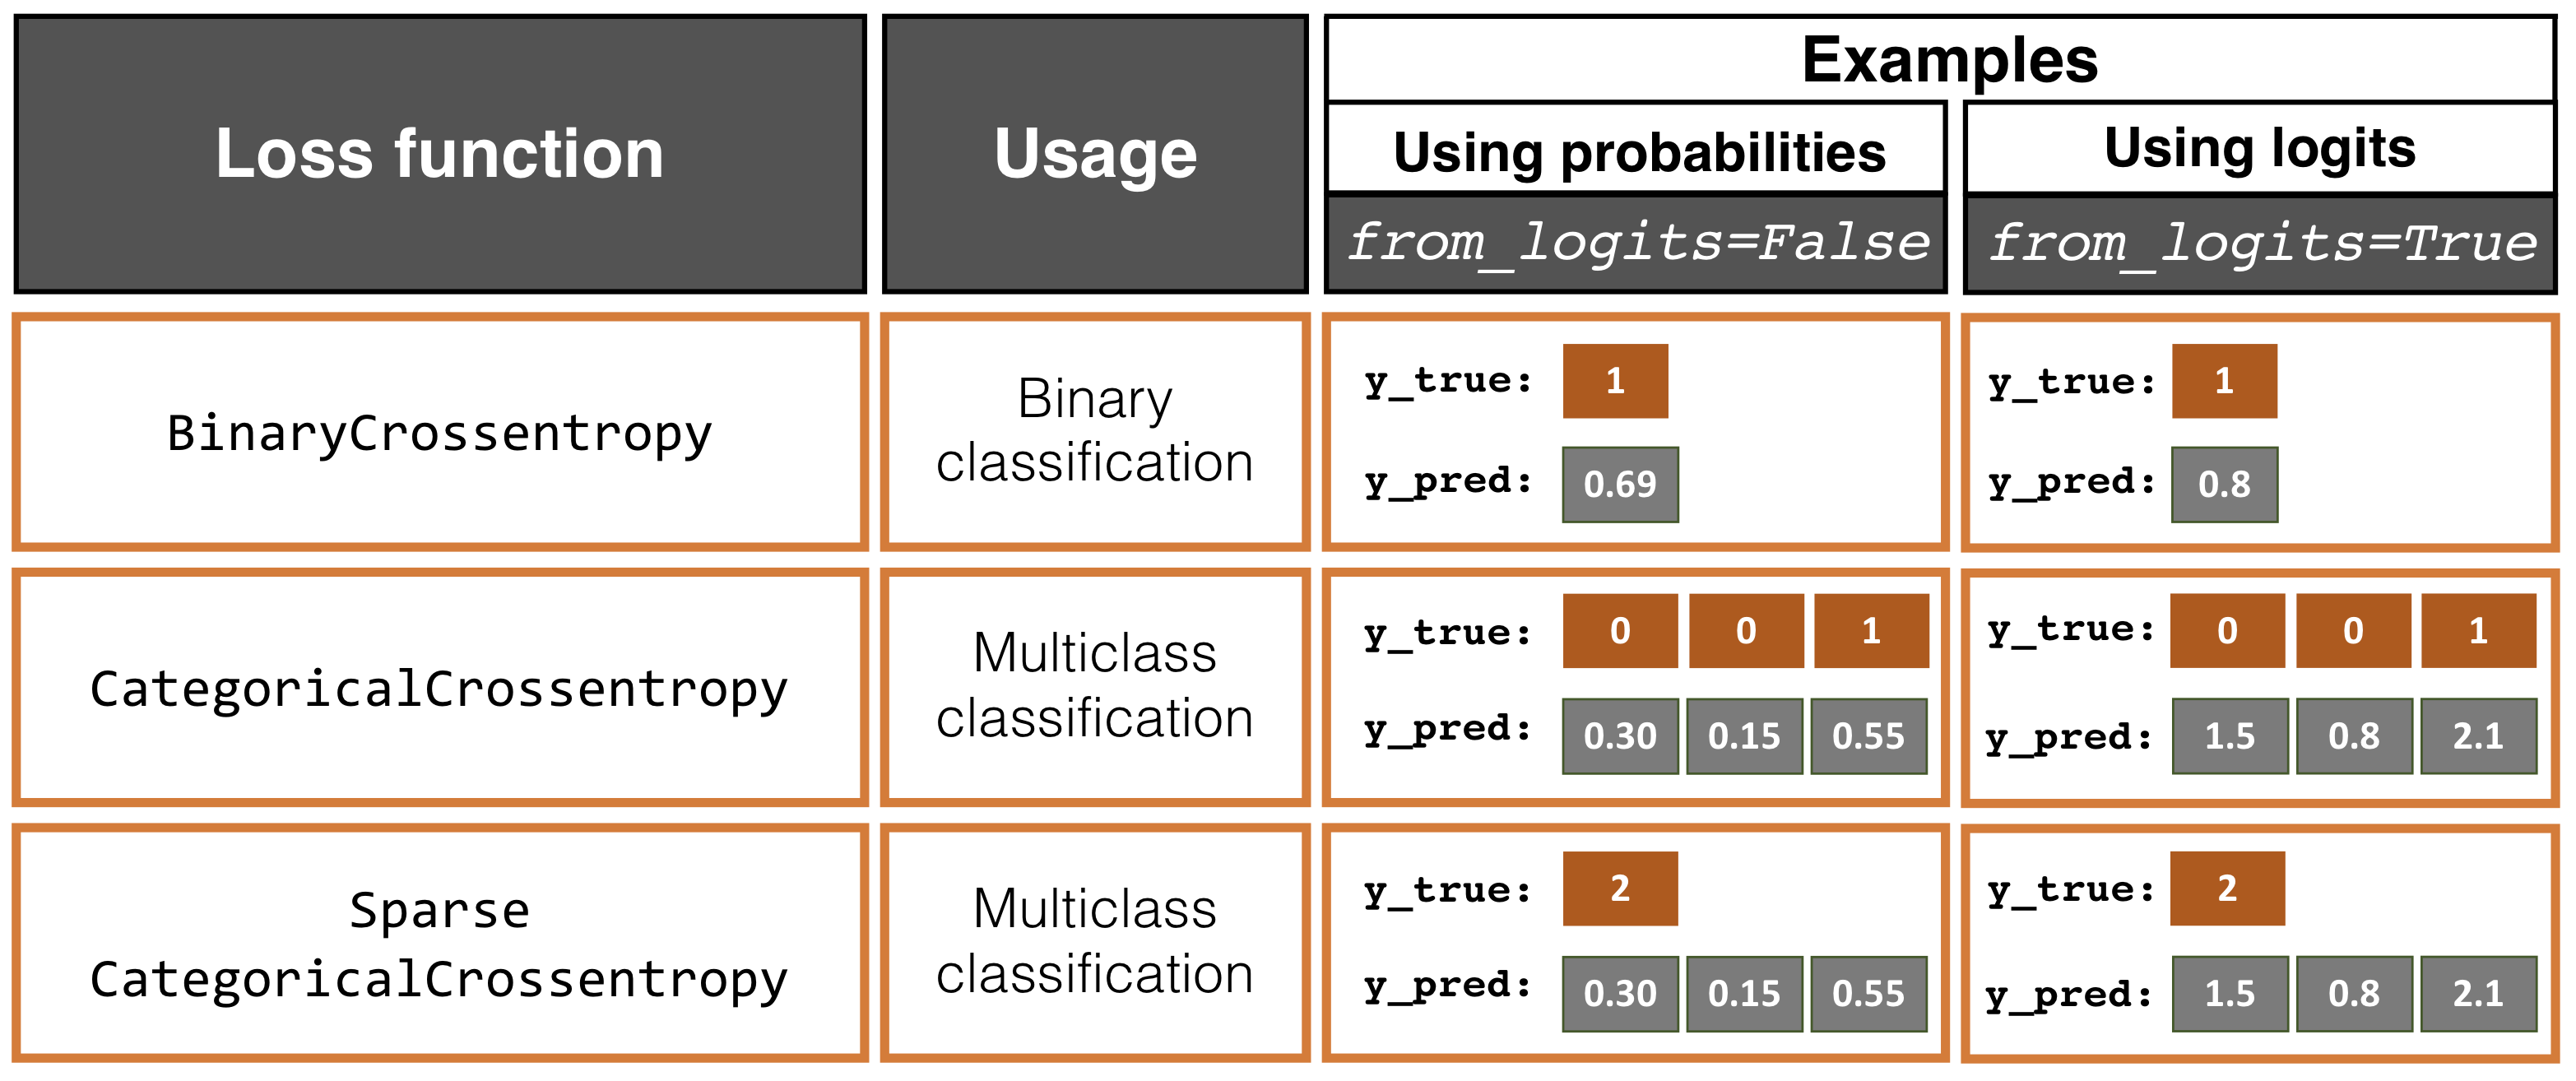

In [21]:
Image(filename='images/15_11.png', width=800)

In [22]:
from distutils.version import LooseVersion as Version


####### Binary Crossentropy
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

if Version(tf.__version__) >= '2.3.0':
    tf.print(
        'CCE (w Probas): {:.4f}'.format(
        cce_probas(y_true=[[0, 0, 1]], y_pred=probas)),
        '(w Logits): {:.4f}'.format(
        cce_logits(y_true=[[0, 0, 1]], y_pred=logits)))
    
else:
    tf.print(
        'CCE (w Probas): {:.4f}'.format(
        cce_probas(y_true=[0, 0, 1], y_pred=probas)),
        '(w Logits): {:.4f}'.format(
        cce_logits(y_true=[0, 0, 1], y_pred=logits)))


####### Categorical Crossentropy
cce_probas = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

tf.print(
    'CCE (w Probas): {:.4f}'.format(
    cce_probas(y_true=[0, 0, 1], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    cce_logits(y_true=[0, 0, 1], y_pred=logits)))

####### Sparse Categorical Crossentropy
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

tf.print(
    'Sparse CCE (w Probas): {:.4f}'.format(
    sp_cce_probas(y_true=[2], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    sp_cce_logits(y_true=[2], y_pred=logits)))

BCE (w Probas): 0.3711 (w Logits): 0.3711
CCE (w Probas): 0.5996 (w Logits): 0.5996
Sparse CCE (w Probas): 0.5996 (w Logits): 0.5996


## Implementing a deep convolutional neural network using TensorFlow

### The multilayer CNN architecture

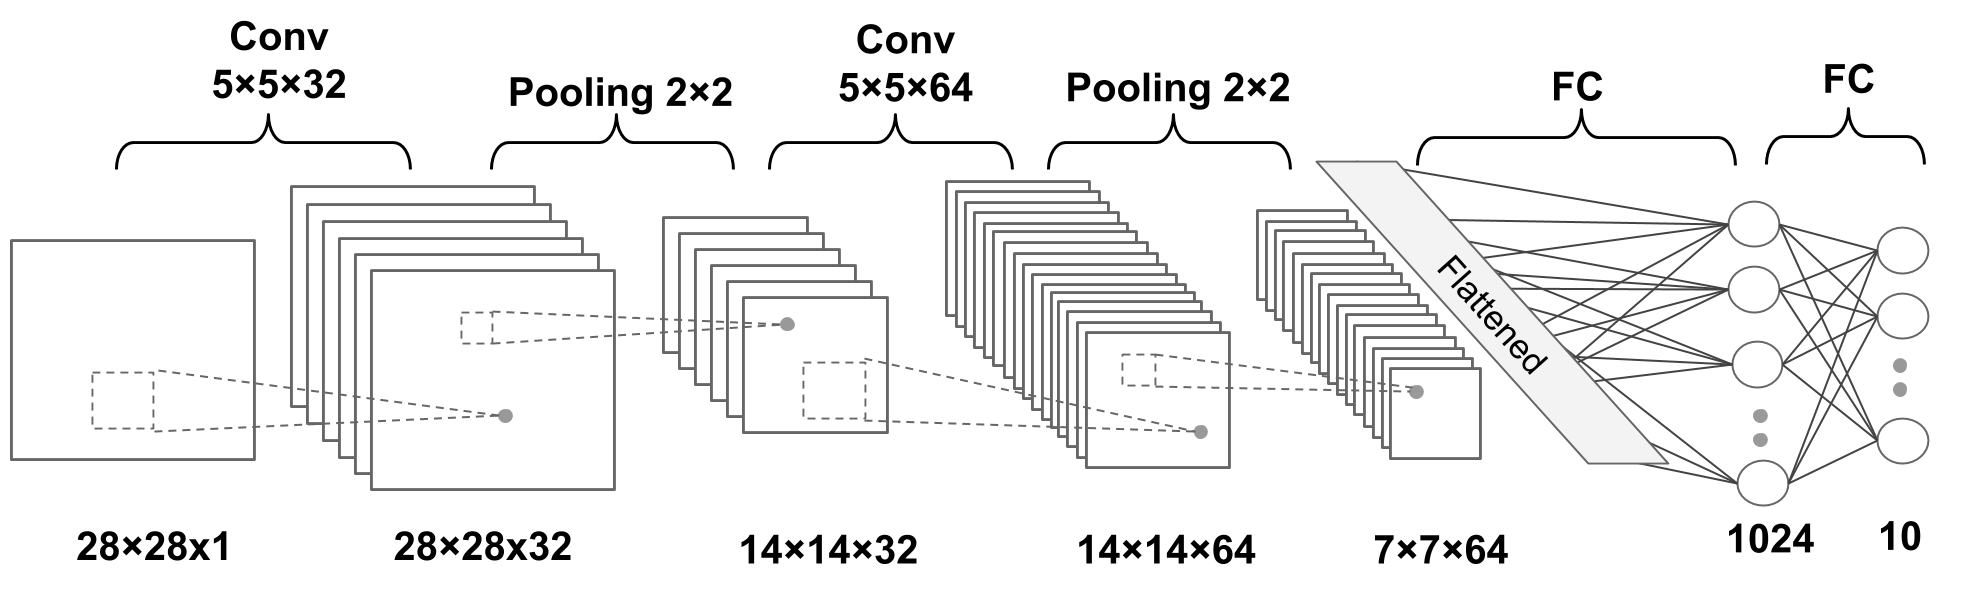

In [23]:
Image(filename='images/15_12.png', width=800)

### Loading and preprocessing the data

In [24]:
import tensorflow_datasets as tfds
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
## MNIST dataset

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['test', 'train'])


In [26]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [27]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### Implementing a CNN using the TensorFlow Keras API

#### Configuring CNN layers in Keras

 * **Conv2D:** `tf.keras.layers.Conv2D`
   * `filters`
   * `kernel_size`
   * `strides`
   * `padding`
   
   
 * **MaxPool2D:** `tf.keras.layers.MaxPool2D`
   * `pool_size`
   * `strides`
   * `padding`
   
   
 * **Dropout** `tf.keras.layers.Dropout2D`
   * `rate`

### Constructing a CNN in Keras

In [28]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))


In [29]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [30]:
    model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [31]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [32]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              multiple                  832       
_________________________________________________________________
pool_1 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
conv_2 (Conv2D)              multiple                  51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
fc_1 (Dense)                 multiple                  3212288   
_________________________________________________________________
dropout (Dropout)            multiple                  0

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 50s 64ms/step - loss: 0.1453 - accuracy: 0.9548 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
782/782 [==============================] - 53s 67ms/step - loss: 0.0489 - accuracy: 0.9857 - val_loss: 0.0375 - val_accuracy: 0.9879
Epoch 3/20
782/782 [==============================] - 58s 75ms/step - loss: 0.0318 - accuracy: 0.9904 - val_loss: 0.0436 - val_accuracy: 0.9863
Epoch 4/20
782/782 [==============================] - 56s 71ms/step - loss: 0.0236 - accuracy: 0.9925 - val_loss: 0.0627 - val_accuracy: 0.9822
Epoch 5/20
782/782 [==============================] - 56s 72ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.0340 - val_accuracy: 0.9912
Epoch 6/20
782/782 [==============================] - 57s 73ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.0516 - val_accuracy: 0.9866
Epoch 7/20
782/782 [==============================] - 57s 73ms/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.0375 - val_a

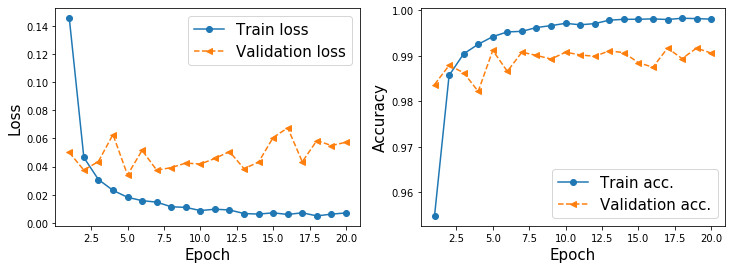

In [35]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()

In [37]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 5s 10ms/step - loss: 0.0443 - accuracy: 0.9929

Test Acc. 99.29%


TensorShape([12, 10])
tf.Tensor([6 2 3 7 2 2 3 4 7 6 6 9], shape=(12,), dtype=int64)


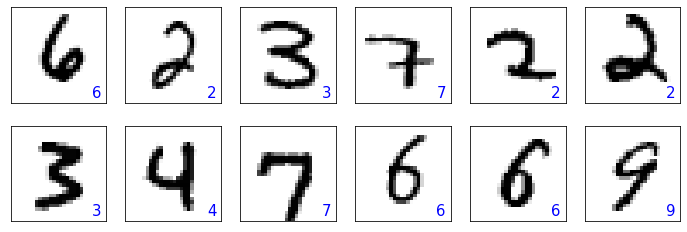

In [38]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()

In [39]:
import os

if not os.path.exists('models'):
    os.mkdir('models')


model.save('models/mnist-cnn.h5')

----

Readers may ignore the next cell.

In [40]:
! python ../.convert_notebook_to_script.py --input ch15_part1.ipynb --output ch15_part1.py

[NbConvertApp] Converting notebook ch15_part1.ipynb to script
[NbConvertApp] Writing 11781 bytes to ch15_part1.py
